# Simulador de Estratégia Collar Up & In

## Autor
Desenvolvido por: Caio Araújo
Cargo: Assessor de Investimentos na SARON Investimentos

## Disclaimer Importante

**AVISO: USO INTERNO EXCLUSIVO**

Este simulador e todas as informações contidas neste documento são de uso exclusivo e confidencial da SARON Investimentos. É estritamente proibido o compartilhamento, distribuição ou divulgação deste material para terceiros, especialmente clientes. Este simulador é uma ferramenta interna de análise e não deve ser utilizado como base para recomendações de investimento sem a devida diligência e análise profissional.

## Funcionalidade do Código

Este código foi desenvolvido especificamente para simular e analisar a estratégia de investimento Collar Up & In. É importante notar que esta implementação é exclusiva para esta estrutura e não deve ser utilizada para outros tipos de estratégias de opções sem as devidas modificações.

### Principais Características:

1. **Simulação de Preços**: 
   - Utiliza um modelo de simulação para gerar possíveis trajetórias de preços do ativo subjacente.
   - Baseia-se em dados históricos para calibrar o modelo de simulação.

2. **Cálculo de Payoffs**:
   - Implementa a lógica específica da estratégia Collar Up & In:
     - Limita a perda máxima (proteção put).
     - Permite ganhos até a barreira de knockout.
     - Limita o ganho máximo após atingir a barreira de knockout.

3. **Análise Estatística**:
   - Calcula o valor esperado da estratégia.
   - Gera estatísticas descritivas dos payoffs (máximo, mínimo, mediana, desvio padrão).
   - Calcula probabilidades de diferentes cenários (payoff positivo, perda máxima, ganho máximo).

4. **Visualização de Resultados**:
   - Gera um histograma da distribuição dos payoffs.
   - Cria um gráfico de dispersão mostrando a relação entre preços finais e payoffs.
   - Inclui linhas de referência para pontos críticos (preço inicial, barreira de knockout, ganho/perda máximos).

### Limitações e Considerações:

- Este código é otimizado para a estrutura Collar Up & In e não deve ser usado diretamente para outras estratégias de opções.
- Os parâmetros da estratégia (preço inicial, barreira de knockout, perda máxima, ganho máximo) são fixos e devem ser ajustados manualmente para diferentes cenários.
- A precisão da simulação depende da qualidade dos dados históricos e do número de iterações utilizadas.

### Uso Recomendado:

Este simulador é ideal para analistas internos da SARON que desejam:
- Avaliar o perfil de risco-retorno da estratégia Collar Up & In.
- Entender o comportamento da estratégia em diferentes cenários de mercado.
- Comparar diferentes configurações de parâmetros para a estratégia Collar Up & In.

Para adaptar este código a outras estratégias ou ativos, será necessário modificar significativamente a lógica de cálculo de payoffs e, possivelmente, o modelo de simulação de preços.

Lembre-se: Este simulador é uma ferramenta de análise interna e seus resultados não devem ser compartilhados diretamente com clientes ou utilizados como única base para recomendações de investimento.

### Funções 

In [1]:
import whale_wallet as ww
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def business_days_between(start_date, end_date):
    # Convert strings to datetime objects if necessary
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Use numpy's busday_count to count business days
    business_days = np.busday_count(start_date.date(), end_date.date())
    
    return business_days

def remove_outliers(x, y, threshold=3):
    if len(x) < 2:  # If there are fewer than 2 points, return the original arrays
        return x, y
    z_scores = np.abs((x - np.mean(x)) / np.std(x))
    mask = z_scores < threshold
    filtered_x = x[mask]
    filtered_y = y[mask]
    if len(filtered_x) < 2:  # If filtering results in fewer than 2 points, return original arrays
        return x, y
    return filtered_x, filtered_y

def calculate_strategy_payoff(final_prices, S0, strike_call, threshold,max_loss,limited_gain):
    if isinstance(final_prices, (int, float, np.number)):
        final_prices = np.array([final_prices])
    
    payoffs = np.zeros(len(final_prices))
    scenarios = np.zeros(len(final_prices), dtype=int)  # 0: downside, 1: normal upside, 2: knockout scenario 2, 3: knockout scenario 1
    
    for i, final_price in enumerate(final_prices):
        if final_price <= S0:
            # Downside scenario with maximum loss of 10%
            payoffs[i] = max(final_price - S0, S0 * max_loss)
            scenarios[i] = 0
        elif final_price > threshold:
            # Knockout scenario 1: maximum gain of 18%
            payoffs[i] = S0 * limited_gain
            scenarios[i] = 3
        elif final_price > strike_call:
            # Knockout scenario 2: limit gain to 18%
            payoffs[i] = min(final_price - S0, S0 * limited_gain)
            scenarios[i] = 2
        else:
            # Normal upside scenario
            payoffs[i] = final_price - S0
            scenarios[i] = 1
    
    scenario_counts = {
        "downside": np.sum(scenarios == 0),
        "normal_upside": np.sum(scenarios == 1),
        "knockout_scenario2": np.sum(scenarios == 2),
        "knockout_scenario1": np.sum(scenarios == 3)
    }
    
    return payoffs, scenario_counts, scenarios

def flatten_and_filter(arr):
    flattened = []
    for item in arr:
        if isinstance(item, (list, np.ndarray)):
            flattened.extend(flatten_and_filter(item))
        elif isinstance(item, (int, float, np.number)):
            flattened.append(item)
    return np.array(flattened)

def run_simulation_and_calculate_payoff(S0, cdf_empirical_interpolated, sorted_values, t_intervals, iterations, strike_call, threshold_percentage):
    simulation = ww.Simulation(S0, cdf_empirical_interpolated, sorted_values)
    simulation_result = simulation._run_collarui_simulation(t_intervals, iterations, 1, threshold_percentage)
    
    # Flatten the simulation result and filter out non-numeric values
    final_prices = flatten_and_filter(simulation_result)
    
    #print(f"Shape of final_prices: {final_prices.shape}")
    #print(f"First few final prices: {final_prices[:5]}")
    
    threshold = S0 * (1 + threshold_percentage)
    
    payoffs, scenario_counts, scenarios = calculate_strategy_payoff(final_prices, S0, strike_call, threshold, max_loss, limited_gain)
    expected_value = np.mean(payoffs)
    
    return payoffs, scenario_counts, final_prices, expected_value, scenarios

### (Opcional) Descobrindo dias úteis:
* Utilize esta secção para descobrir a quantidade de dias úteis da operação estruturada.

In [34]:
start = '2024-10-01'
end = '2025-02-07'
print(f"Quantidadade de dias úteis entre {start} -> {end} ==> {business_days_between(start, end)} Dias")

Quantidadade de dias úteis entre 2024-10-01 -> 2025-02-07 ==> 93 Dias


# Inputs para a Estratégia Collar Up & In
* Leia cuidadosamente a Lâmina da operação COLLAR UI e identifique os seguintes parâmetros:

In [35]:
# Ativo-objeto: BPAC11 (Banco BTG Pactual)
ativo = "VALE3"

# Dias até o vencimento
t_intervals = 93

# Preço de referência (S0): R$ 32,80
S0 = 63.51

# Perda máxima oferecida pela proteção put: -10%
max_loss = -0.05

# Barreira de knockout: +34% acima do preço de referência
threshold_percentage = 0.1346

# Ganho limitado ao evento de knockout: +18%
limited_gain = 0.048

# Exibição dos parâmetros
print(f"Ativo: {ativo}")
print(f"Preço de Referência (S0): R$ {S0:.2f}")
print(f"Perda Máxima: {max_loss:.2%}")
print(f"Barreira de Knockout: {threshold_percentage:.2%} acima de S0")
print(f"Ganho Máximo: {limited_gain:.2%}")

# Cálculos adicionais
barreira_knockout = S0 * (1 + threshold_percentage)
perda_maxima = S0 * max_loss
ganho_maximo = S0 * limited_gain

print(f"\nValores calculados:")
print(f"Barreira de Knockout: R$ {barreira_knockout:.2f}")
print(f"Perda Máxima: R$ {perda_maxima:.2f}")
print(f"Ganho Limitado Máximo: R$ {ganho_maximo:.2f}")
print(f"Estrutura com prazo de {t_intervals} úteis")

Ativo: VALE3
Preço de Referência (S0): R$ 63.51
Perda Máxima: -5.00%
Barreira de Knockout: 13.46% acima de S0
Ganho Máximo: 4.80%

Valores calculados:
Barreira de Knockout: R$ 72.06
Perda Máxima: R$ -3.18
Ganho Limitado Máximo: R$ 3.05
Estrutura com prazo de 93 úteis


## Escolha o número de simulações
* Recomendado entre 10mil - 50 mil
* Número de simulações ATENÇÃO PARA CAPACIDADE COMPUTACIONAL DE SUA MÁQUINA NÃO RECOMENDADO ACIMA DE 100MIL.

In [36]:
iterations = 50000

## Gerando Relatório

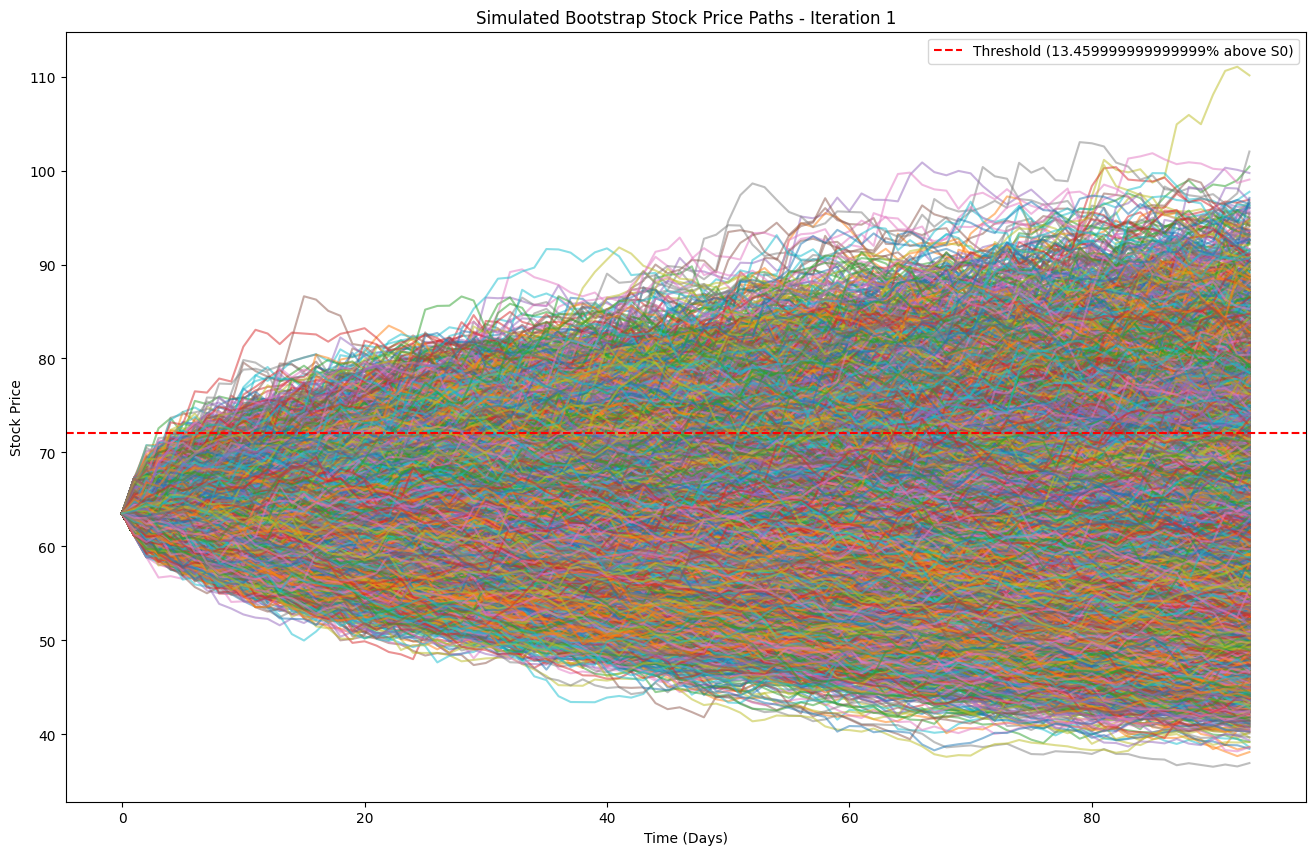

Total Simulations: 50000
Nº de trajetórias que atingiram barreira knockout: 11656
% de trajetórias knockout: 23.31%


In [37]:

strike_call = S0 * (1 + threshold_percentage)
period = str(t_intervals) + 'd'
asset_df = ww.ydata(ticker_symbol=ativo, period=period).get_stock_data()
returns_calc = ww.ReturnsCalculator(asset_df)
returns_calc.calculate_returns()
log_returns = returns_calc.log_returns
sorted_values = returns_calc.sorted_values
interpolated_cdf_values = returns_calc.interpolated_cdf_values

# Run the simulation and calculate payoffs
payoffs, scenario_counts, final_prices, expected_value, scenarios = run_simulation_and_calculate_payoff(
    S0, interpolated_cdf_values, sorted_values, t_intervals, iterations, strike_call, threshold_percentage
)



Estatísticas dos Cenários:
downside: 30238 (60.47%)
normal_upside: 14147 (28.29%)
knockout_scenario2: 0 (0.00%)
knockout_scenario1: 5616 (11.23%)


c:\Users\ojuar\anaconda3\envs\Vanilla\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


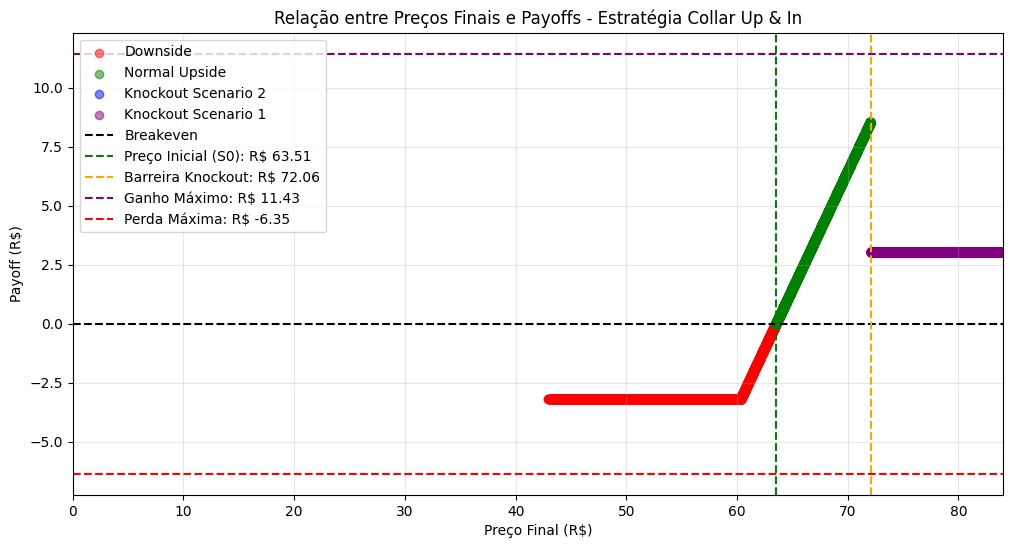

In [38]:

# Display scenario statistics
total_paths = sum(scenario_counts.values())
print("\nEstatísticas dos Cenários:")
for scenario, count in scenario_counts.items():
    percentage = (count / total_paths) * 100
    print(f"{scenario}: {count} ({percentage:.2f}%)")


# Plot the relationship between final prices and payoffs
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue', 'purple']
labels = ['Downside', 'Normal Upside', 'Knockout Scenario 2', 'Knockout Scenario 1']

for scenario in range(4):
    mask = scenarios == scenario
    x, y = remove_outliers(final_prices[mask], payoffs[mask])
    plt.scatter(x, y, alpha=0.5, color=colors[scenario], label=labels[scenario])

plt.title('Relação entre Preços Finais e Payoffs - Estratégia Collar Up & In')
plt.xlabel('Preço Final (R$)')
plt.ylabel('Payoff (R$)')
plt.axhline(y=0, color='black', linestyle='--', label='Breakeven')
plt.axvline(x=S0, color='g', linestyle='--', label=f'Preço Inicial (S0): R$ {S0:.2f}')
plt.axvline(x=strike_call, color='orange', linestyle='--', label=f'Barreira Knockout: R$ {strike_call:.2f}')
plt.axhline(y=S0*0.18, color='purple', linestyle='--', label=f'Ganho Máximo: R$ {S0*0.18:.2f}')
plt.axhline(y=S0*-0.10, color='red', linestyle='--', label=f'Perda Máxima: R$ {S0*-0.10:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Ajustar os limites do eixo x para focar na região relevante
x_max = np.percentile(final_prices, 99)  # Use o 99º percentil como limite máximo
plt.xlim(0, x_max)

plt.show()

Estatísticas dos Payoffs:
Máximo: R$ 8.55
Mínimo: R$ -3.18
Mediana: R$ -2.18
Média: R$ -0.29
Desvio Padrão: R$ 3.39
Ganho Limitado: R$ 3.05

Probabilidades:
Probabilidade de Ganho Limitado: 0.00%
Probabilidade de Payoff Positivo: 39.53%
Probabilidade de Payoff Negativo: 60.47%
Probabilidade de Perda Máxima: 0.00%

Valor Esperado da Estratégia: R$ -0.29
Este resultado indica que, considerando todos os cenários simulados, a estratégia tende a produzir um ganho médio de R$ -0.29 por unidade de investimento.


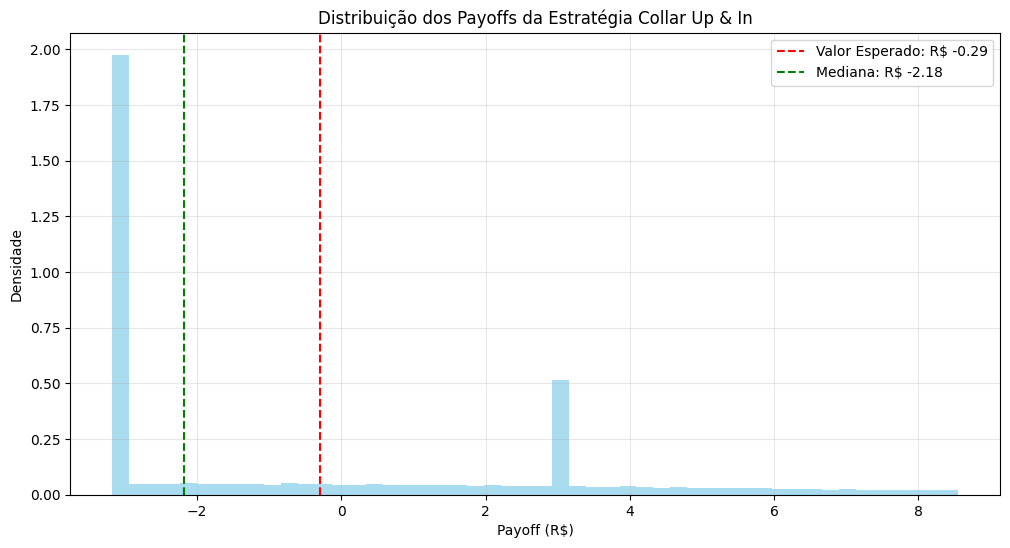

In [39]:
# Calcular e imprimir estatísticas adicionais
max_payoff = np.max(payoffs)
min_payoff = np.min(payoffs)
median_payoff = np.median(payoffs)
mean_payoff = np.mean(payoffs)
std_dev_payoff = np.std(payoffs)
limited_payoff = S0 * limited_gain

print("Estatísticas dos Payoffs:")
print(f"Máximo: R$ {max_payoff:.2f}")
print(f"Mínimo: R$ {min_payoff:.2f}")
print(f"Mediana: R$ {median_payoff:.2f}")
print(f"Média: R$ {mean_payoff:.2f}")
print(f"Desvio Padrão: R$ {std_dev_payoff:.2f}")
print(f"Ganho Limitado: R$ {limited_payoff:.2f}")

# Calcular probabilidades
prob_positive_payoff = np.mean(payoffs > 0)
prob_negative_payoff = np.mean(payoffs < 0)
prob_zero_payoff = np.mean(np.isclose(payoffs, 0))
prob_max_loss = np.mean(np.isclose(payoffs, S0 * -0.10, atol=1e-6))
prob_max_gain = np.mean(np.isclose(payoffs, S0 * 0.18, atol=1e-6))

print("\nProbabilidades:")
print(f"Probabilidade de Ganho Limitado: {prob_max_gain:.2%}")
print(f"Probabilidade de Payoff Positivo: {prob_positive_payoff:.2%}")
print(f"Probabilidade de Payoff Negativo: {prob_negative_payoff:.2%}")
print(f"Probabilidade de Perda Máxima: {prob_max_loss:.2%}")

print(f"\nValor Esperado da Estratégia: R$ {expected_value:.2f}")
print(f"Este resultado indica que, considerando todos os cenários simulados, a estratégia tende a produzir um ganho médio de R$ {expected_value:.2f} por unidade de investimento.") 
# Histograma dos payoffs
plt.figure(figsize=(12, 6))
plt.hist(payoffs, bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Distribuição dos Payoffs da Estratégia Collar Up & In')
plt.xlabel('Payoff (R$)')
plt.ylabel('Densidade')
plt.axvline(mean_payoff, color='r', linestyle='--', label=f'Valor Esperado: R$ {mean_payoff:.2f}')
plt.axvline(median_payoff, color='g', linestyle='--', label=f'Mediana: R$ {median_payoff:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()